In [ ]:
# drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
path = '/content/drive/MyDrive/Project  RUL'
evchargedata = os.path.join(path, 'evchargedata.csv')
evtripdata = os.path.join(path, 'evtripdata.csv')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt

# Load the data
charge_data = pd.read_csv(evchargedata)
trip_data = pd.read_csv(evtripdata)

# Convert date columns to datetime objects
charge_data['BatteryChargeStartDate'] = pd.to_datetime(charge_data['BatteryChargeStartDate'])
charge_data['BatteryChargeStopDate'] = pd.to_datetime(charge_data['BatteryChargeStopDate'])
trip_data['TripStartDateTime'] = pd.to_datetime(trip_data['TripStartDateTime'])
trip_data['TripStopDateTime'] = pd.to_datetime(trip_data['TripStopDateTime'])

# Sort trip data to correctly calculate cumulative sums
trip_data = trip_data.sort_values(by=['ParticipantID', 'TripStartDateTime']).reset_index(drop=True)

# Calculate cumulative features
trip_data['CumulativeDistance_m'] = trip_data.groupby('ParticipantID')['TripDistance (m)'].cumsum()
trip_data['CumulativeEnergy_Wh'] = trip_data.groupby('ParticipantID')['Power Consumption (Wh)'].cumsum()

# latest trip features for each day to merge with charging data
daily_trip_summary = trip_data.groupby([
    'ParticipantID',
    trip_data['TripStartDateTime'].dt.date
])[['CumulativeDistance_m', 'CumulativeEnergy_Wh']].max().reset_index()

daily_trip_summary = daily_trip_summary.rename(columns={'TripStartDateTime': 'Date'})
print("Processed Trip Data (Cumulative Features):\n", daily_trip_summary.head())

Processed Trip Data (Cumulative Features):
   ParticipantID        Date  CumulativeDistance_m  CumulativeEnergy_Wh
0          BL01  2014-07-04                8441.0               1267.0
1          BL01  2014-07-05              164990.0              28420.0
2          BL01  2014-07-07              341599.0              57016.0
3          BL01  2014-07-08              414961.0              68288.0
4          BL01  2014-07-09              496931.0              79870.0


In [ ]:
# Calculate Charge Duration in minutes and SoC Change
charge_data['ChargeDuration_min'] = (charge_data['BatteryChargeStopDate'] - charge_data['BatteryChargeStartDate']).dt.total_seconds() / 60
charge_data['SoC_Change'] = charge_data['Ending SoC (of 12)'] - charge_data['Starting SoC (of 12)']

# Define SOH Proxy (Cycle Count)
charge_data['Cycle_Count'] = charge_data.groupby('ParticipantID').cumcount() + 1
charge_data['SOH_Proxy'] = charge_data['Cycle_Count']

# Aggregate by ParticipantID and Date (using Charge Start Date)
charge_data['Date'] = charge_data['BatteryChargeStartDate'].dt.date
daily_charge_summary = charge_data.groupby(['ParticipantID', 'Date']).agg(
    Avg_ChargeDuration=('ChargeDuration_min', 'mean'),
    Total_SoC_Change=('SoC_Change', 'sum'),
    Max_SOH_Proxy=('SOH_Proxy', 'max')
).reset_index()

print("\nProcessed Charge Data (Features & SOH Proxy):\n", daily_charge_summary.head())


Processed Charge Data (Features & SOH Proxy):
   ParticipantID        Date  Avg_ChargeDuration  Total_SoC_Change  \
0          BL01  2014-07-08               141.0                12   
1          BL01  2014-07-09                92.8                 9   
2          BL01  2014-07-10               208.0                 5   
3          BL01  2014-07-11               662.0                 9   
4          BL01  2014-07-14               330.0                10   

   Max_SOH_Proxy  
0             17  
1             22  
2             23  
3             24  
4             26  


In [ ]:
# Merge the charge and trip data based on ParticipantID and Date
final_data = pd.merge(daily_charge_summary, daily_trip_summary, on=['ParticipantID', 'Date'], how='left')

# Drop rows where trip data is missing
final_data = final_data.dropna().sort_values(by=['ParticipantID', 'Date']).reset_index(drop=True)

# Select final features and target
features = ['Avg_ChargeDuration', 'Total_SoC_Change', 'CumulativeDistance_m', 'CumulativeEnergy_Wh']
target = 'Max_SOH_Proxy'
data_for_lstm = final_data[['ParticipantID', target] + features].copy()

print("\nFinal Merged Dataset (Per Day):\n", data_for_lstm.head())


Final Merged Dataset (Per Day):
   ParticipantID  Max_SOH_Proxy  Avg_ChargeDuration  Total_SoC_Change  \
0          BL01             17               141.0                12   
1          BL01             22                92.8                 9   
2          BL01             23               208.0                 5   
3          BL01             24               662.0                 9   
4          BL01             26               330.0                10   

   CumulativeDistance_m  CumulativeEnergy_Wh  
0              414961.0              68288.0  
1              496931.0              79870.0  
2              560655.0              89166.0  
3              679513.0             105143.0  
4              784986.0             120934.0  


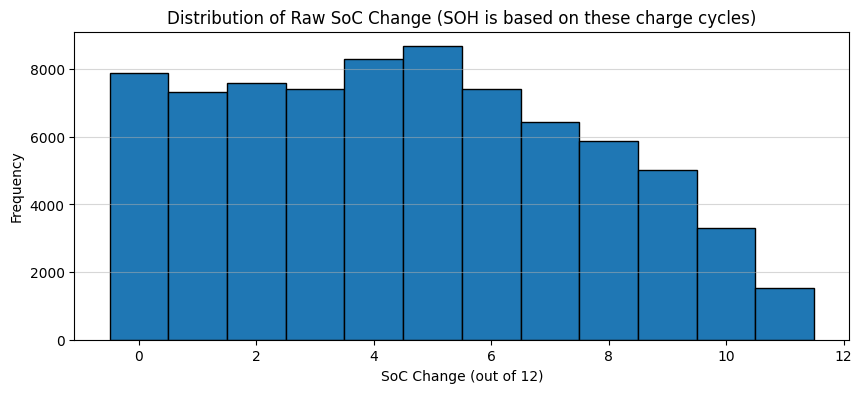

In [ ]:
plt.figure(figsize=(10, 4))
plt.hist(charge_data['SoC_Change'], bins=np.arange(0, 13, 1), align='left', edgecolor='black')
plt.title('Distribution of Raw SoC Change (SOH is based on these charge cycles)')
plt.xlabel('SoC Change (out of 12)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.5)
plt.show()


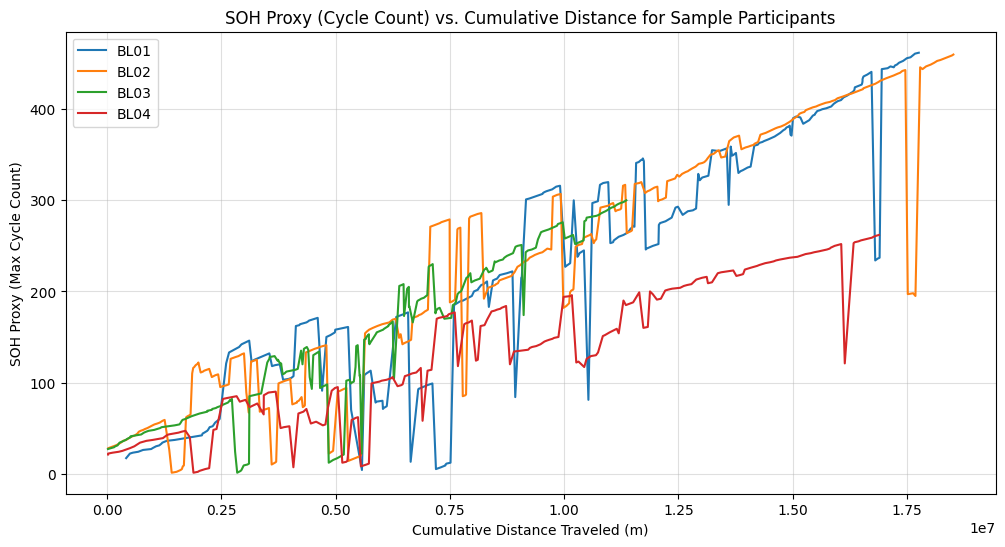

In [ ]:
sample_participants = data_for_lstm['ParticipantID'].unique()[:4]
plt.figure(figsize=(12, 6))

for pid in sample_participants:
    subset = data_for_lstm[data_for_lstm['ParticipantID'] == pid]
    plt.plot(subset['CumulativeDistance_m'], subset['Max_SOH_Proxy'], label=pid)

plt.title('SOH Proxy (Cycle Count) vs. Cumulative Distance for Sample Participants')
plt.xlabel('Cumulative Distance Traveled (m)')
plt.ylabel('SOH Proxy (Max Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()


In [ ]:
# Scale the features (X) and the SOH proxy (y)
scaler_X = MinMaxScaler()
data_for_lstm[features] = scaler_X.fit_transform(data_for_lstm[features])

scaler_y = MinMaxScaler()
data_for_lstm[target] = scaler_y.fit_transform(data_for_lstm[[target]])

# Function to create time series sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length, 1:])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

SEQUENCE_LENGTH = 10

# Group by participant and create sequences
X_sequences, y_sequences = [], []

for pid in data_for_lstm['ParticipantID'].unique():
    pid_data = data_for_lstm[data_for_lstm['ParticipantID'] == pid].drop('ParticipantID', axis=1).values

    if len(pid_data) > SEQUENCE_LENGTH:
        X_p, y_p = create_sequences(pid_data, SEQUENCE_LENGTH)
        X_sequences.append(X_p)
        y_sequences.append(y_p)

X_combined = np.concatenate(X_sequences)
y_combined = np.concatenate(y_sequences)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42, shuffle=False)

print(f"\nTraining Data Shape: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"Testing Data Shape: X_test {X_test.shape}, y_test {y_test.shape}")


Training Data Shape: X_train (39291, 10, 4), y_train (39291,)
Testing Data Shape: X_test (9823, 10, 4), y_test (9823,)


In [ ]:
# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(SEQUENCE_LENGTH, X_train.shape[2])),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=0
)

print("LSTM Model Training Complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


LSTM Model Training Complete.


In [ ]:
# Make predictions
y_pred_scaled = model.predict(X_test, verbose=0)

# Inverse transform to get back the original cycle count
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))
y_pred_original = scaler_y.inverse_transform(y_pred_scaled)

# Calculate metrics
r2 = r2_score(y_test_original, y_pred_original)
mae = mean_absolute_error(y_test_original, y_pred_original)

print(f"\n## 📈 LSTM Prediction Performance")
print(f"**R2 Score:** {r2:.4f} (Closer to 1.0 is better)")
print(f"**Mean Absolute Error (MAE):** {mae:.2f} Cycles (Average error in cycle prediction)")


## 📈 LSTM Prediction Performance
**R2 Score:** 0.7678 (Closer to 1.0 is better)
**Mean Absolute Error (MAE):** 39.35 Cycles (Average error in cycle prediction)


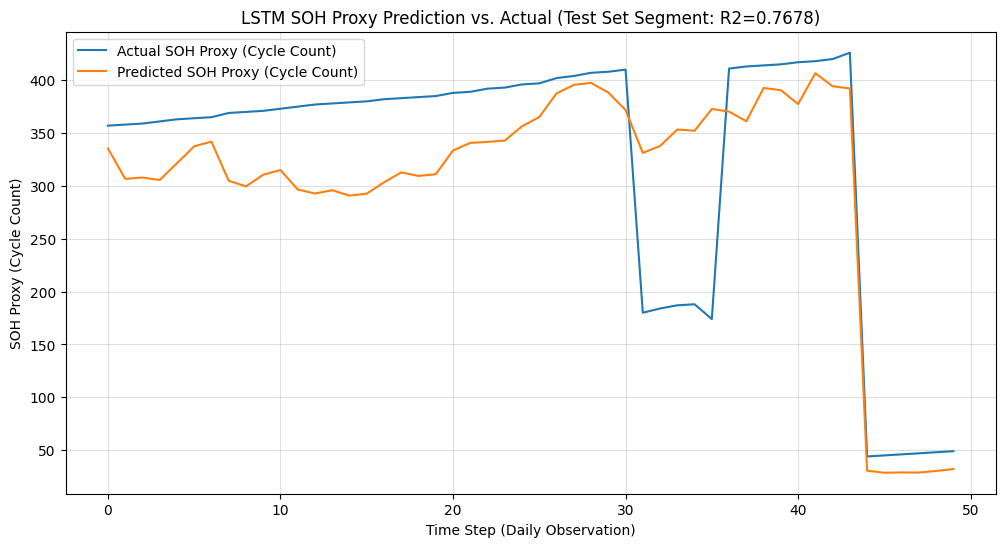

In [ ]:
plt.figure(figsize=(12, 6))
# Only plot a segment of the test set for clarity, as it's a long time series
segment_length = 50
plt.plot(y_test_original[:segment_length], label='Actual SOH Proxy (Cycle Count)')
plt.plot(y_pred_original[:segment_length], label='Predicted SOH Proxy (Cycle Count)')
plt.title(f'LSTM SOH Proxy Prediction vs. Actual (Test Set Segment: R2={r2:.4f})')
plt.xlabel('Time Step (Daily Observation)')
plt.ylabel('SOH Proxy (Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()
print("")

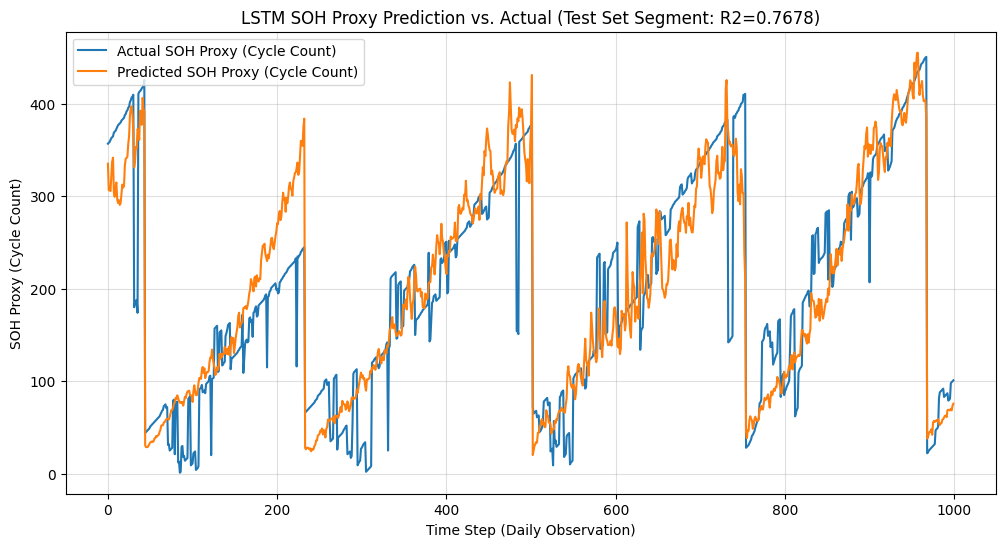

In [ ]:
plt.figure(figsize=(12, 6))
# Only plot a segment of the test set for clarity, as it's a long time series
segment_length = 1000
plt.plot(y_test_original[:segment_length], label='Actual SOH Proxy (Cycle Count)')
plt.plot(y_pred_original[:segment_length], label='Predicted SOH Proxy (Cycle Count)')
plt.title(f'LSTM SOH Proxy Prediction vs. Actual (Test Set Segment: R2={r2:.4f})')
plt.xlabel('Time Step (Daily Observation)')
plt.ylabel('SOH Proxy (Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()


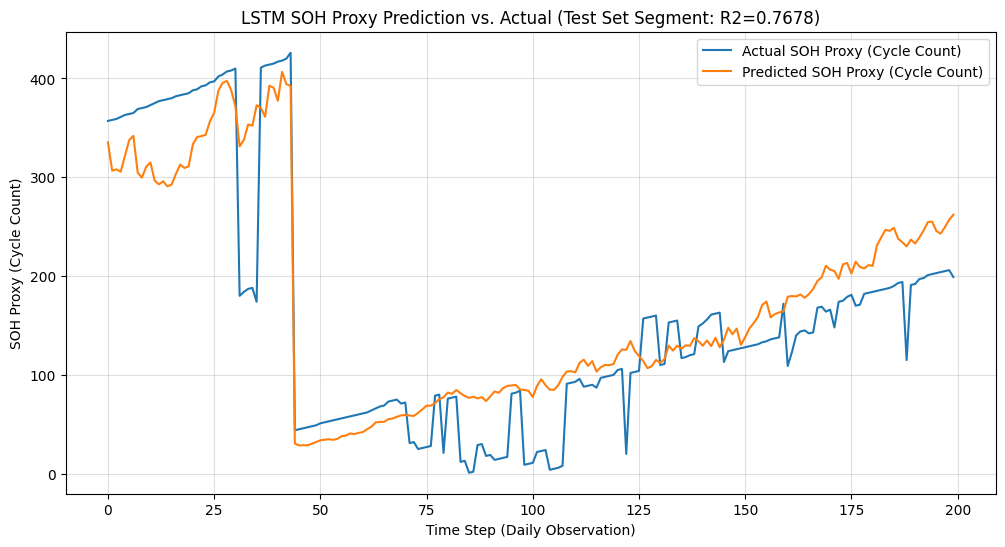

In [ ]:
plt.figure(figsize=(12, 6))
# Only plot a segment of the test set for clarity, as it's a long time series
segment_length = 200
plt.plot(y_test_original[:segment_length], label='Actual SOH Proxy (Cycle Count)')
plt.plot(y_pred_original[:segment_length], label='Predicted SOH Proxy (Cycle Count)')
plt.title(f'LSTM SOH Proxy Prediction vs. Actual (Test Set Segment: R2={r2:.4f})')
plt.xlabel('Time Step (Daily Observation)')
plt.ylabel('SOH Proxy (Cycle Count)')
plt.legend()
plt.grid(alpha=0.4)
plt.show()
print("")